In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
!ls -lrt ../../data/

ls: ../data/: No such file or directory


In [3]:
data = pd.read_csv('../../data/train.csv')

In [4]:
# columns in data
data.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [5]:
# drop id column
data.drop('id', axis=1, inplace=True)

In [6]:
# get the types of columns
data.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object

In [7]:
# check if it has any missing values
data.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [8]:
# for the non-object columns, get the summary statistics
data.describe()

,model_year,milage,price
count,54273.000000,54273.000000,5.427300e+04
mean,2015.091979,72746.175667,3.921844e+04
std,5.588909,50469.490448,7.282634e+04
min,1974.000000,100.000000,2.000000e+03
25%,2012.000000,32268.000000,1.550000e+04
50%,2016.000000,66107.000000,2.800000e+04
75%,2019.000000,102000.000000,4.500000e+04
max,2024.000000,405000.000000,2.954083e+06


In [9]:
# get the unique values in the object columns
data.select_dtypes(include=['object']).apply(pd.Series.nunique)

brand             53
model           1827
fuel_type          7
engine          1061
transmission      46
ext_col          260
int_col          124
accident           2
clean_title        1
dtype: int64

<Axes: xlabel='price', ylabel='Count'>

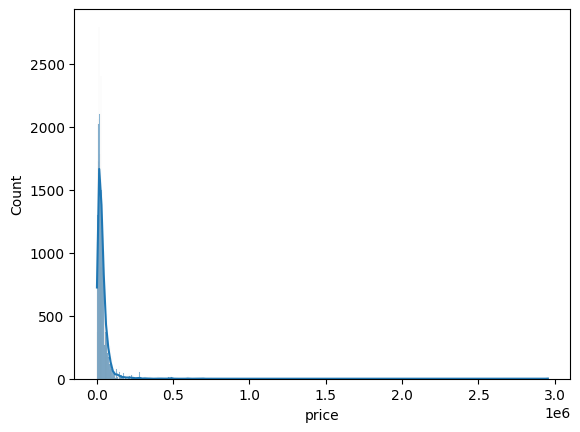

In [10]:
# show the distribution of the target variable
sns.histplot(data['price'], kde=True, label='price')

In [11]:
# drop price column and map remaining columns to dictionary
X_dicts = data.drop('price', axis=1).to_dict(orient='records')
y = data['price']

In [12]:
# split into train and test
from sklearn.model_selection import train_test_split

# divide the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_dicts, y, test_size=0.2, random_state=42)
# split test set into validation and test sets (10% validation, 10% test)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [13]:
X_train[0], y_train[0]

({'brand': 'Toyota',
  'model': '4Runner Limited',
  'model_year': 2016,
  'milage': 163000,
  'fuel_type': 'Gasoline',
  'engine': '270.0HP 4.0L V6 Cylinder Engine Gasoline Fuel',
  'transmission': '5-Speed A/T',
  'ext_col': 'White',
  'int_col': 'Beige',
  'accident': 'None reported',
  'clean_title': 'Yes'},
 11000)

# Vectorize Data

In [14]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer() # transform lists of mappings (dict-like objects) of feature names to feature values into Numpy arrays
X_train = dv.fit_transform(X_train)
X_test = dv.transform(X_test)
X_val = dv.transform(X_val)

print(X_train.shape, X_test.shape, X_val.shape)

(43418, 3342) (5427, 3342) (5428, 3342)


# Hyperparameter Search

In [15]:
import mlflow
from sklearn.ensemble import ExtraTreesRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from sklearn.metrics import root_mean_squared_error

In [16]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("hyperopt")

2024/05/31 15:06:44 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/05/31 15:06:44 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/Users/gbemidebe/Documents/GitHub/KaggleXSkillAssessmentChallenge/notebooks/ExtraTreesRegressor/mlruns/1', creation_time=1717186005083, experiment_id='1', last_update_time=1717186005083, lifecycle_stage='active', name='hyperopt', tags={}>

In [19]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "ExtraTreesRegressor")
        mlflow.log_params(params)
        booster = ExtraTreesRegressor(**params)
        booster.fit(X_train, y_train)
        y_pred = booster.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [22]:
search_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 1000, 2)),
    'max_depth': hp.quniformint('max_depth', 1, 20),
    'min_samples_split': hp.uniform('min_samples_split', 0.01, 1),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.5),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'oob_score': hp.choice('oob_score', [True, False])
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=Trials(), 
)

  1%|          | 1/100 [00:01<02:55,  1.77s/trial, best loss: 51584.18748309327]

ERROR [hyperopt.fmin] job exception: Out of bag estimation only available if bootstrap=True


  1%|          | 1/100 [00:01<02:56,  1.78s/trial, best loss: 51584.18748309327]


ValueError: Out of bag estimation only available if bootstrap=True

In [ ]:
best_result

In [ ]:
import pickle

mlflow.set_experiment("best_model_xgboost")

with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    mlflow.xgboost.autolog()

    # set the best hyperparameters
    best_result['max_depth'] = int(best_result['max_depth'])

    booster = xgb.train(
        params=best_result,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50, verbose_eval=False
    )

    rmse_train = root_mean_squared_error(y_train, booster.predict(train))
    rmse_val = root_mean_squared_error(y_val, booster.predict(valid))

    print(f"Train RMSE: {rmse_train:.2f}")
    print(f"Validation RMSE: {rmse_val:.2f}")


    with open("./preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

## Test model

In [ ]:
test_data_orig = pd.read_csv('../../data/test.csv')

In [ ]:
test_data_orig.head()

In [ ]:
# ensure the columns are in the same order as the training data
test_data =  test_data_orig[data.columns[:-1]]
test_data.head()

In [ ]:
# drop price column and map remaining columns to dictionary
X_test = test_data.to_dict(orient='records')
X_test[0]

In [ ]:
# load the preprocessor
with open("./preprocessor.b", "rb") as f_in:
    dv = pickle.load(f_in)

X_test = dv.transform(X_test)

In [ ]:
# predict the price
y_pred_test = booster.predict(xgb.DMatrix(X_test))

In [ ]:
# append the predictions as price to the test data and save the id and price columns
test_data_orig['price'] = y_pred_test

In [ ]:
# save the test data with the predictions as a csv file. add date to the filename
test_data_orig[['id', 'price']].to_csv(f'../../data/predictions_{pd.Timestamp.now()}.csv', index=False)